### Fruit quality classifier

Importing libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import shutil
from pathlib import Path
import torchnet as tnt
from torchvision.datasets import ImageFolder

In [3]:
np.random.seed(1)
torch.manual_seed(1)

In [4]:
container_path = "/home/pupadhyay/Fruit_detection/dataset/big"

In [5]:
transform = {
        'train': transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.RandomVerticalFlip(), # Flip the data horizontally
#             transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.05),
#             transforms.AugMix(),
#             transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#             transforms.RandomRotation(degrees=(0, 180)),
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([224,224]),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

In [6]:
dataset = ImageFolder(container_path, transform = transform['train'])

In [7]:
dataset_len = len(dataset)
train_split = int(dataset_len * 0.6)
val_split = int(dataset_len * 0.2)
test_split = dataset_len - train_split - val_split
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_split, val_split, test_split])

In [8]:
batch_size = 4
num_workers = 4
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
dataset.class_to_idx

{'no_split': 0, 'split': 1}

In [10]:
classes = dataset.classes

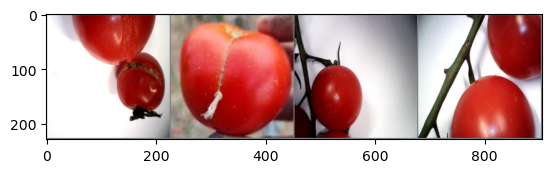

split split no_split no_split


In [11]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = dataiter.next()

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [12]:
class ConvNet(nn.Module):
    ''' Models a simple Convolutional Neural Network'''

    def __init__(self, classes = 2):
        ''' initialize the network '''
        super(ConvNet, self).__init__()
        # 3 input image channel, 6 output channels, 
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 10)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 10) 
        self.fc1 = nn.Linear(16 * 49 * 49, 120)# 53x53 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
#         print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 16 * 49 * 49) # 53x53 from image dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [13]:
net = ConvNet()
print(net)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(10, 10), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(10, 10), stride=(1, 1))
  (fc1): Linear(in_features=38416, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

In [15]:
name = "trial"
runs_dir = Path("/home/pupadhyay/Fruit_detection/runs") / name
if os.path.exists(runs_dir):
    shutil.rmtree(runs_dir)
os.makedirs(runs_dir,  exist_ok = True) 

writer= SummaryWriter(runs_dir)

In [16]:
def show_tensorboard_losses(writer,losses, total_iterations):
        writer.add_scalars('Loss', {
               "train": losses,
                },total_iterations)       
        
def show_tensorboard_val_losses(writer,losses, total_terations):
        writer.add_scalars('Loss', {
               "val": losses,
                },total_terations)

In [17]:
def train_epoch(model, train_loader, writer, total_iterations):
    acc_meter = tnt.meter.ClassErrorMeter(accuracy=True)
    loss_meter = tnt.meter.AverageValueMeter()
    y_true = []
    y_pred = []
    for i, data in enumerate(train_loader, 0):
        total_iterations = total_iterations + batch_size
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        pred = outputs.detach()
        y_p = pred.argmax(dim=1).cpu().numpy()
        y_pred.extend(list(y_p))
        acc_meter.add(pred, labels)
        loss_meter.add(loss.item())

    epoch_metrics = {'train_loss': loss_meter.value()[0],
                     'train_accuracy': acc_meter.value()[0]}
    show_tensorboard_losses(writer, loss_meter.value()[0], total_iterations)
    return total_iterations    

In [18]:
def val(model, val_loader, writer, total_iterations):
    y_true = []
    y_pred = []
    test_results = dict()
    acc_meter = tnt.meter.ClassErrorMeter(accuracy=True)
    loss_meter = tnt.meter.AverageValueMeter()
    for i, data in enumerate(val_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            prediction = net(inputs)
            
            loss = criterion(prediction, labels)
            
        acc_meter.add(prediction, labels)
        loss_meter.add(loss.item())
        y_p = prediction.argmax(dim=1).cpu().numpy()
        y_pred.extend(list(y_p))
    metrics = {'{}_accuracy'.format("val"): acc_meter.value()[0],
               '{}_loss'.format("val"): loss_meter.value()[0]}
    show_tensorboard_val_losses(writer, loss_meter.value()[0], total_iterations)


In [19]:
import torch.nn as nn
import torch.nn.init as init

def weight_init(m):
    '''
    Initializes a model's parameters.
    Credits to: https://gist.github.com/jeasinema

    Usage:
        model = Model()
        model.apply(weight_init)
    '''

    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        try:
            init.normal_(m.bias.data)
        except AttributeError:
            pass

In [20]:
total_iterations = 0

net.apply(weight_init)
for epoch in range(100):  # loop over the dataset multiple times  

    net.train()
    total_iterations = train_epoch(net, train_loader, writer, total_iterations)
    net.eval()
    val(net, val_loader, writer, total_iterations)

In [21]:
# save
PATH = './fruit_net.pth'
torch.save(net.state_dict(), PATH)
# reload
net = ConvNet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

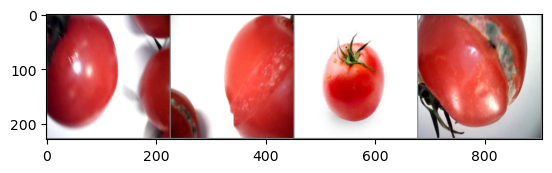

GroundTruth:  no_split split no_split split


In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  no_split no_split no_split split


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [72]:
!python train.py --epochs 100 --lr 0.001 --batch_size 4


Writing arguments to checkpoints/exp/args.json
Epoch:  0 iterations:  16 training loss 4.401871562004089
Epoch:  0 iterations:  36 training loss 2.797591817378998
Epoch:  0 iterations:  56 training loss 2.581332810719808
Epoch:  0 iterations:  76 training loss 2.187293457984924
Epoch:  0 iterations:  96 training loss 1.8872587072849276
Epoch:  0 iterations:  116 training loss 1.6788960188627244
Epoch:  0 iterations:  136 training loss 1.5636550962924958
Validating model
Validation loss 0.6842704812685648
Epoch:  1 iterations:  16 training loss 0.6235747575759888
Epoch:  1 iterations:  36 training loss 0.656292961537838
Epoch:  1 iterations:  56 training loss 0.6887896925210952
Epoch:  1 iterations:  76 training loss 0.7036323569715023
Epoch:  1 iterations:  96 training loss 0.6777774947881698
Epoch:  1 iterations:  116 training loss 0.6792705322305362
Epoch:  1 iterations:  136 training loss 0.6726556739636831
Validating model
Validation loss 0.6072191124161085
Epoch:  2 iterations:  1